# Week 5 - Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [22]:
from __future__ import print_function
import os
#Veri Yolu, sisteminizdeki dosya konumuna göre ayarlanmalıdır
data_path = [os.getcwd()]

In [23]:
#download the data to the work direictry 
import gdown 

gdown.download("https://drive.google.com/uc?id={0}".format("1nnbelp1ZQZOmoBiStb6E87aHDa_U3B_v"),"Human_Activity_Recognition_Using_Smartphones_Data.csv",quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1nnbelp1ZQZOmoBiStb6E87aHDa_U3B_v
To: C:\Users\aabdu\Human_Activity_Recognition_Using_Smartphones_Data.csv
70.6MB [00:58, 1.21MB/s]


'Human_Activity_Recognition_Using_Smartphones_Data.csv'

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [24]:
import pandas as pd
import numpy as np
#Dosya yolu, önceki hücrede ayarlanan data_path'e bağlıdır
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [25]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [26]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [27]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [28]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [29]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

In [30]:
type(data.Activity)

pandas.core.series.Series

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)

data['Activity'].sample(5)

5811     3
2107     1
10178    0
9095     1
612      3
Name: Activity, dtype: int32

In [32]:
data.Activity

0        2
1        2
2        2
3        2
4        2
        ..
10294    5
10295    5
10296    5
10297    5
10298    5
Name: Activity, Length: 10299, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [33]:
# Korelasyon değerlerini hesaplama
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Köşegen altındaki tüm verileri boşaltarak basitleştirin
tril_index = np.tril_indices_from(corr_values)

# Kullanılmayan değerleri NaN yapın|
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Verileri istifleyin ve dataframe'e dönüştürün
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Sıralama için mutlak değerleri alın
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

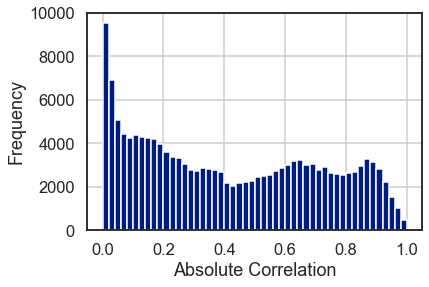

In [35]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [36]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [37]:
data.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
tBodyAcc-mean()-X,0.288585,0.278419,0.279653,0.279174,0.276629,0.277199,0.279454,0.277432,0.277293,0.280586,0.276880,0.276228,0.278457,0.277175,0.297946,0.279203,0.279038,0.280135,0.277731,0.275568
tBodyAcc-mean()-Y,-0.020294,-0.016411,-0.019467,-0.026201,-0.016570,-0.010098,-0.019641,-0.030488,-0.021751,-0.009960,-0.012722,-0.021441,-0.020415,-0.014713,0.027094,-0.023020,-0.014800,-0.013917,-0.018211,-0.016980
tBodyAcc-mean()-Z,-0.132905,-0.123520,-0.113462,-0.123283,-0.115362,-0.105137,-0.110022,-0.125360,-0.120751,-0.106065,-0.103438,-0.108202,-0.112732,-0.106756,-0.061668,-0.122080,-0.116849,-0.106370,-0.109188,-0.111429
tBodyAcc-std()-X,-0.995279,-0.998245,-0.995380,-0.996091,-0.998139,-0.997335,-0.996921,-0.996559,-0.997328,-0.994803,-0.994815,-0.998246,-0.999135,-0.999188,-0.988641,-0.996839,-0.996941,-0.997695,-0.997491,-0.997811
tBodyAcc-std()-Y,-0.983111,-0.975300,-0.967187,-0.983403,-0.980817,-0.990487,-0.967186,-0.966728,-0.961245,-0.972758,-0.973077,-0.987214,-0.984680,-0.990526,-0.816699,-0.974848,-0.981866,-0.987516,-0.993222,-0.990522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",-0.018446,0.703511,0.808529,-0.485366,-0.615971,-0.368224,-0.189512,0.467383,0.117797,-0.070670,0.115931,-0.651945,0.765485,0.498814,-0.268791,-0.056927,-0.229155,0.367557,0.788193,-0.411729
"angle(X,gravityMean)",-0.841247,-0.844788,-0.848933,-0.848649,-0.847865,-0.849632,-0.852150,-0.851017,-0.847971,-0.848294,-0.851562,-0.852723,-0.850654,-0.849773,-0.730937,-0.761101,-0.759172,-0.759363,-0.761052,-0.760620
"angle(Y,gravityMean)",0.179941,0.180289,0.180637,0.181935,0.185151,0.184823,0.182170,0.183779,0.188982,0.190310,0.187609,0.186050,0.187611,0.188812,0.283159,0.263119,0.264324,0.264033,0.262886,0.263169
"angle(Z,gravityMean)",-0.058627,-0.054317,-0.049118,-0.047663,-0.043892,-0.042126,-0.043010,-0.041976,-0.037364,-0.034417,-0.034681,-0.035852,-0.035998,-0.035063,0.036444,0.024172,0.027014,0.029664,0.029346,0.029573


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [39]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [40]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [41]:
from sklearn.linear_model import LogisticRegression

# Standart lojistik regresyon
lr = LogisticRegression().fit(X_train, y_train)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
#Calculating Details for lr Model
print('lr Model Train Score is : ' , lr.score(X_train, y_train))
print('lr Model Test Score is : ' , lr.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr.predict(X_test)
print('Predicted Value for lr Model is : ' , y_pred[:10])


lr Model Train Score is :  0.9877930364821751
lr Model Test Score is :  0.9802588996763754
----------------------------------------------------
Predicted Value for lr Model is :  [3 5 3 1 0 5 0 2 0 0]


In [43]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [44]:
#Calculating Details for lr_l1 Model
print('lr_l1 Model Train Score is : ' , lr_l1.score(X_train, y_train))
print('lr_l1 Model Test Score is : ' , lr_l1.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1.predict(X_test)
print('Predicted Value for lr_l1 Model is : ' , y_pred[:10])

lr_l1 Model Train Score is :  0.9929255097794424
lr_l1 Model Test Score is :  0.9841423948220065
----------------------------------------------------
Predicted Value for lr_l1 Model is :  [3 5 3 1 0 5 0 2 0 0]


In [45]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [46]:
#Calculating Details for lr_l2 Model
print('lr_l2 Model Train Score is : ' , lr_l2.score(X_train, y_train))
print('lr_l2 Model Test Score is : ' , lr_l2.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2.predict(X_test)
print('Predicted Value for lr_l2 Model is : ' , y_pred[:10])

lr_l2 Model Train Score is :  0.9940352337356083
lr_l2 Model Test Score is :  0.9838187702265372
----------------------------------------------------
Predicted Value for lr_l2 Model is :  [3 5 3 1 0 5 0 2 0 0]


In [47]:
# "Newton-cg", "lbfgs", "sag", "saga" gibi farklı çözücülerle deneyin ve gözlemlerinizi paylaşın

In [48]:
#penalty='l2', solver='newton-cg'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_newton_cg = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_train, y_train)

In [49]:
#Calculating Details for lr_l2_newton_cg Model
print('lr_l2_newton_cg Model Train Score is : ' , lr_l2_newton_cg.score(X_train, y_train))
print('lr_l2_newton_cg Model Test Score is : ' , lr_l2_newton_cg.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg.predict(X_test)
print('Predicted Value for lr_l2_newton_cg Model is : ' , y_pred[:10])

lr_l2_newton_cg Model Train Score is :  0.9944513802191705
lr_l2_newton_cg Model Test Score is :  0.983495145631068
----------------------------------------------------
Predicted Value for lr_l2_newton_cg Model is :  [3 5 3 1 0 5 0 2 0 0]


In [50]:
#penalty='l2', solver='lbfgs'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l2_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_train, y_train)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [51]:
#Calculating Details for lr_l2_lbfgs Model
print('lr_l2_lbfgs Model Train Score is : ' , lr_l2_lbfgs.score(X_train, y_train))
print('lr_l2_lbfgs Model Test Score is : ' , lr_l2_lbfgs.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l2_lbfgs Model Train Score is :  0.9940352337356083
lr_l2_lbfgs Model Test Score is :  0.9838187702265372
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


In [52]:
#penalty='l2', solver='sag'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag').fit(X_train, y_train)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

In [53]:
#Calculating Details for lr_l2_sag Model
print('lr_l2_sag Model Train Score is : ' , lr_l2_sag.score(X_train, y_train))
print('lr_l2_sag Model Test Score is : ' , lr_l2_sag.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_sag.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l2_sag Model Train Score is :  0.9955611041753364
lr_l2_sag Model Test Score is :  0.9844660194174757
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


In [54]:
#penalty='l1', solver='saga'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

In [55]:
#Calculating Details for lr_l1_saga Model
print('lr_l1_saga Model Train Score is : ' , lr_l1_saga.score(X_train, y_train))
print('lr_l1_saga Model Test Score is : ' , lr_l1_saga.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_saga.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l1_saga Model Train Score is :  0.994728811208212
lr_l1_saga Model Test Score is :  0.9838187702265372
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [56]:
# Combine all the coefficients into a dataframe
coefficients = list()

#coeff_labels = ['lr', 'l1', 'l2']
#coeff_models = [lr, lr_l1, lr_l2]

coeff_labels = ['lr', 'l1', 'l2'   , 'lr_l2_newton_cg' , 'lr_l2_lbfgs' , 'lr_l2_sag' , 'lr_l1_saga']
coeff_models = [ lr , lr_l1, lr_l2 ,  lr_l2_newton_cg  , lr_l2_lbfgs   ,  lr_l2_sag  ,  lr_l1_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10).T


258       113       477       127       288       363  \
lr              0 -0.020168  0.083750 -0.006011 -0.088134 -0.195781 -0.160367   
                1  0.024897 -0.231017  0.047744 -0.013212 -0.226767 -0.146078   
                2  0.078342  0.317968  0.092792 -0.145669 -0.299033 -0.073149   
                3 -0.040483  0.014179 -0.197676  0.339381  0.321861  0.028726   
                4 -0.004384  0.000722  0.138204 -0.184492  0.173587  0.394841   
                5 -0.038204 -0.185601 -0.075053  0.092126  0.226133 -0.043973   
l1              0  0.000000  0.000000  0.000000  0.000000  0.000000 -0.056826   
                1  0.000000  0.000000  0.409147  0.000000  1.012400  0.000000   
                2  0.000000  0.000000  0.217880  0.000000 -1.813752  0.000000   
                3  0.000000  0.000000  0.000000  0.863270  1.752177  0.179667   
                4 -0.016564  0.000000  0.004022 -0.566311  0.000000  0.168846   
                5  0.000000 -0.933199  0.245122  0.000000  0.434109 -1.428598   
l2              0 -0.072669  0.049696 -0.073054 -0.050651 -0.088929 -0.110400   
                1 -0.001279 -0.159271  0.020003 -0.081332  0.195192 -0.243882   
                2  0.109215  0.227924  0.109192 -0.090426 -0.627177  0.042358   
                3 -0.013707  0.027482 -0.200756  0.396058  0.393304  0.090989   
                4 -0.012976  0.060700  0.190951 -0.322192  0.002781  0.422105   
                5 -0.008584 -0.206532 -0.046336  0.148542  0.124828 -0.201170   
lr_l2_newton_cg 0 -0.003888  0.041982 -0.001913 -0.016613 -0.107681 -0.068326   
                1 -0.031635 -0.089537 -0.012746 -0.082119  0.246913 -0.291549   
                2  0.015277  0.133227  0.009418 -0.136780 -0.570243  0.061107   
                3  0.001586  0.034710 -0.194683  0.388105  0.375223  0.110311   
                4  0.003357  0.064811  0.212774 -0.303282 -0.044720  0.403805   
                5  0.015303 -0.185193 -0.012850  0.150689  0.100508 -0.215347   
lr_l2_lbfgs     0 -0.072669  0.049696 -0.073054 -0.050651 -0.088929 -0.110400   
                1 -0.001279 -0.159271  0.020003 -0.081332  0.195192 -0.243882   
                2  0.109215  0.227924  0.109192 -0.090426 -0.627177  0.042358   
                3 -0.013707  0.027482 -0.200756  0.396058  0.393304  0.090989   
                4 -0.012976  0.060700  0.190951 -0.322192  0.002781  0.422105   
                5 -0.008584 -0.206532 -0.046336  0.148542  0.124828 -0.201170   
lr_l2_sag       0 -0.090426  0.063976 -0.090730 -0.069435 -0.119729 -0.138975   
                1 -0.008843 -0.111819  0.017525 -0.055493  0.176982 -0.329268   
                2  0.153034  0.202868  0.154047 -0.152439 -0.729529  0.077311   
                3 -0.027944  0.037177 -0.253713  0.503410  0.507351  0.099345   
                4 -0.015962  0.066351  0.235438 -0.407234  0.009107  0.519013   
                5 -0.009858 -0.258553 -0.062569  0.181192  0.155819 -0.227426   
lr_l1_saga      0 -0.056808  0.068327 -0.059037 -0.017510 -0.035253 -0.091660   
                1 -0.010409 -0.141305 -0.003479 -0.043412  0.265330 -0.166452   
                2  0.106790  0.073969  0.111829 -0.015277 -0.669160  0.101306   
                3 -0.006110  0.015924 -0.080740  0.377849  0.296749  0.052083   
                4 -0.003610  0.001898  0.075426 -0.237697 -0.023827  0.403692   
                5 -0.000077 -0.081479 -0.012384  0.092065  0.050817 -0.135722   

                        366       15        498       339  
lr              0 -0.294892 -0.033058 -0.003073 -0.016611  
                1 -0.517702 -0.121383  0.047872  0.039632  
                2 -0.075991 -0.096505  0.090480  0.070558  
                3  0.205084 -0.007781 -0.093774 -0.070954  
                4  0.210735  0.076099 -0.094272  0.154280  
                5  0.472767  0.182628  0.052766 -0.176906  
l1              0  0.000000  0.000000  0.000000  0.000000  
                1 -1.620277 -0.556469  0.459153  0.000000  


Prepare six separate plots for each of the multi-class coefficients.

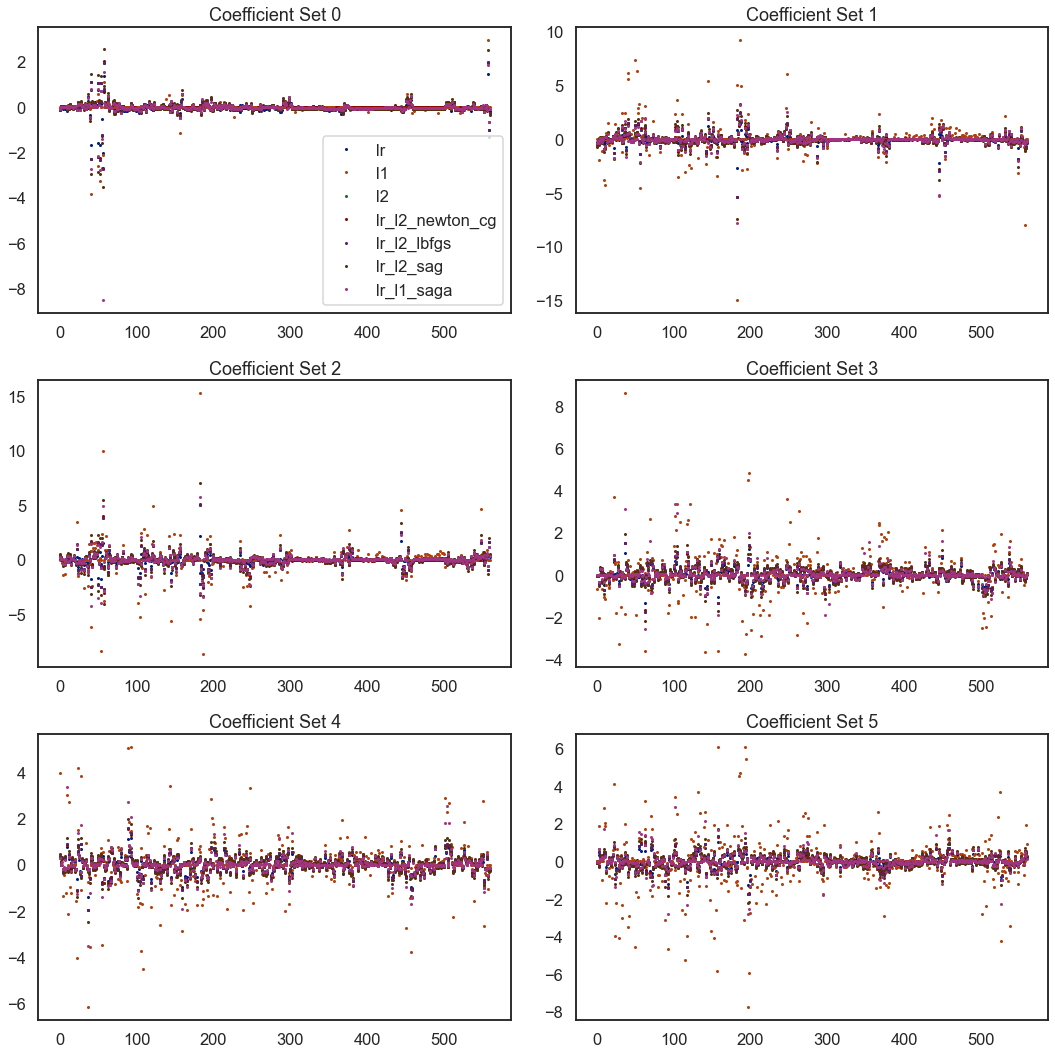

In [57]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15,15)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [58]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2'   , 'lr_l2_newton_cg' , 'lr_l2_lbfgs' , 'lr_l2_sag' , 'lr_l1_saga']
coeff_models = [ lr , lr_l1, lr_l2 ,  lr_l2_newton_cg  , lr_l2_lbfgs   ,  lr_l2_sag  ,  lr_l1_saga]
for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
0,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0


In [59]:
y_prob.head()

,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
0,0.999995,0.998971,0.999998,0.999999,0.999998,1.000000,1.000000
1,0.999238,0.999469,0.999727,0.999650,0.999727,0.999976,0.999976
2,0.997355,0.995513,0.999135,0.998874,0.999135,0.999850,0.999878
3,0.988715,0.999209,0.997804,0.997837,0.997804,0.999718,0.999630
4,0.995040,0.999920,0.999476,0.999326,0.999476,0.999864,0.999625


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [60]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Çok sınıflı destek fonksiyonunda Precision, recall, f-score 
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # accuracy'yi hesaplamanın olağan yolu
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC skorları verilerin ikilileştirilmesi(binarizing) ile hesaplanabilir
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Son olarak, confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [61]:
# Metrikleri çalıştırın
metrics

,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
precision,0.980246,0.984153,0.983811,0.983485,0.983811,0.984456,0.983810
recall,0.980259,0.984142,0.983819,0.983495,0.983819,0.984466,0.983819
fscore,0.980248,0.984140,0.983811,0.983488,0.983811,0.984459,0.983812
accuracy,0.980259,0.984142,0.983819,0.983495,0.983819,0.984466,0.983819
auc,0.988042,0.990342,0.990167,0.989983,0.990167,0.990564,0.990162


## Question 8

Display or plot the confusion matrix for each model.

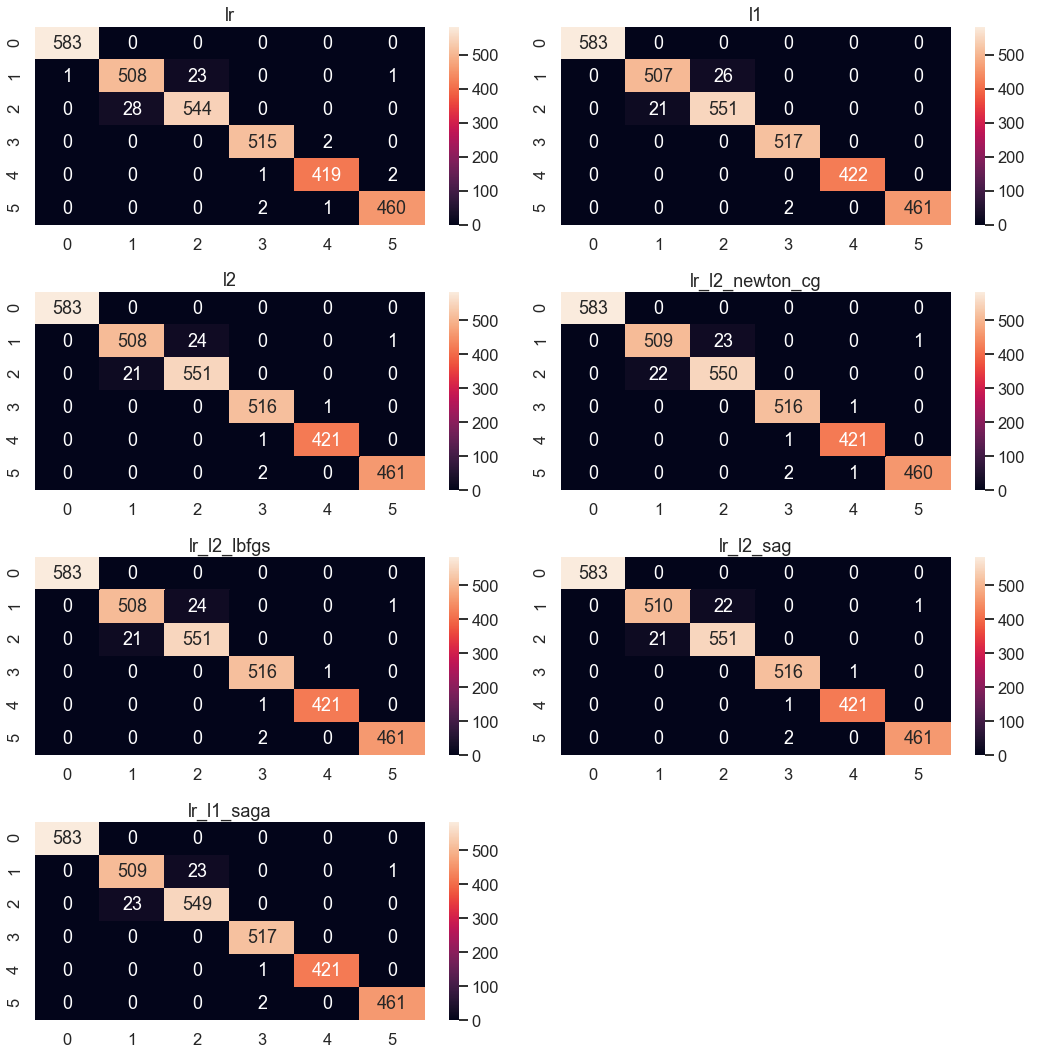

In [62]:

fig, axList = plt.subplots(nrows=4, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15, 15)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [64]:
# Try standard, L1 and L2 Logistic regression

In [65]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr_1 = LogisticRegression().fit(X_new, Y_new)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
#Calculating Details for lr1 Model
print('lr_1 Train Score is : ' , lr_1.score(X_new, Y_new))
print('lr_1 Test Score is : ' , lr_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_1.predict(X_test_new)
print('Predicted Value for lr_1 Model is : ' , y_pred[:10])

lr_1 Train Score is :  0.21582081822889695
lr_1 Test Score is :  0.18019417475728156
----------------------------------------------------
Predicted Value for lr_1 Model is :  [0 2 0 3 0 2 2 2 1 0]


In [67]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_new, Y_new)

In [68]:
#Calculating Details for lr_l1_1 Model
print('lr_l1_1 Model Train Score is : ' , lr_l1_1.score(X_new, Y_new))
print('lr_l1_1 Model Test Score is : ' , lr_l1_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_1.predict(X_test_new)
print('Predicted Value for lr_l1_1 Model is : ' , y_pred[:10])

lr_l1_1 Model Train Score is :  0.19368203003625065
lr_l1_1 Model Test Score is :  0.19262135922330098
----------------------------------------------------
Predicted Value for lr_l1_1 Model is :  [0 0 0 0 2 0 0 2 2 2]


In [69]:
# L2 regularized logistic regression
lr_l2_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_new, Y_new)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [70]:
#Calculating Details for lr_l2_1 Model
print('lr_l2_1 Model Train Score is : ' , lr_l2_1.score(X_new, Y_new))
print('lr_l2_1 Model Test Score is : ' , lr_l2_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_1.predict(X_test_new)
print('Predicted Value for lr_l2_1 Model is : ' , y_pred[:10])

lr_l2_1 Model Train Score is :  0.19368203003625065
lr_l2_1 Model Test Score is :  0.19262135922330098
----------------------------------------------------
Predicted Value for lr_l2_1 Model is :  [0 0 0 0 2 0 0 2 2 2]


In [71]:
# ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ gibi farklı çözümler deneyin ve gözlemleyin

In [72]:
#penalty='l2', solver='newton-cg'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_newton_cg_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_new, Y_new)

In [73]:
#Calculating Details for lr_l2_newton_cg_1 Model
print('lr_l2_newton_cg_1 Model Train Score is : ' , lr_l2_newton_cg_1.score(X_new, Y_new))
print('lr_l2_newton_cg_1 Model Test Score is : ' , lr_l2_newton_cg_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg_1.predict(X_test_new)
print('Predicted Value for lr_l2_newton_cg_1 Model is : ' , y_pred[:10])

lr_l2_newton_cg_1 Model Train Score is :  0.19368203003625065
lr_l2_newton_cg_1 Model Test Score is :  0.19262135922330098
----------------------------------------------------
Predicted Value for lr_l2_newton_cg_1 Model is :  [0 0 0 0 2 0 0 2 2 2]


In [74]:
#penalty='l2', solver='lbfgs'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l2_lbfgs_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_new, Y_new)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [75]:
#Calculating Details for lr_l2_lbfgs_1 Model
print('lr_l2_lbfgs_1 Model Train Score is : ' , lr_l2_lbfgs_1.score(X_new, Y_new))
print('lr_l2_lbfgs_1 Model Test Score is : ' , lr_l2_lbfgs_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_lbfgs_1.predict(X_test_new)
print('Predicted Value for lr_l2_lbfgs_1 Model is : ' , y_pred[:10])

lr_l2_lbfgs_1 Model Train Score is :  0.19368203003625065
lr_l2_lbfgs_1 Model Test Score is :  0.19262135922330098
----------------------------------------------------
Predicted Value for lr_l2_lbfgs_1 Model is :  [0 0 0 0 2 0 0 2 2 2]


In [76]:
#penalty='l1', solver='saga'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_saga_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_new, Y_new)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

In [77]:
#Calculating Details for lr_l1_saga_1 Model
print('lr_l1_saga_1 Model Train Score is : ' , lr_l1_saga_1.score(X_new, Y_new))
print('lr_l1_saga_1 Model Test Score is : ' , lr_l1_saga_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_saga_1.predict(X_test_new)
print('Predicted Value for lr_l1_saga_1 Model is : ' , y_pred[:10])

lr_l1_saga_1 Model Train Score is :  0.18928016571724496
lr_l1_saga_1 Model Test Score is :  0.1871844660194175
----------------------------------------------------
Predicted Value for lr_l1_saga_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [78]:
#penalty='l2', solver='sag'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_sag_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag').fit(X_new, Y_new)

C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

In [79]:
#Calculating Details for lr_l2_sag_1 Model
print('lr_l2_sag_1 Model Train Score is : ' , lr_l2_sag_1 .score(X_new, Y_new))
print('lr_l2_sag1 Model Test Score is : ' , lr_l2_sag_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_sag_1.predict(X_test_new)
print('Predicted Value for lr_l2_sag_1 Model is : ' , y_pred[:10])

lr_l2_sag_1 Model Train Score is :  0.19368203003625065
lr_l2_sag1 Model Test Score is :  0.19262135922330098
----------------------------------------------------
Predicted Value for lr_l2_sag_1 Model is :  [0 0 0 0 2 0 0 2 2 2]


## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [80]:
# Combine all the coefficients into a dataframe for comparison


In [81]:
# Tüm katsayıları bir dataframe'de birleştirin 
coefficients1 = list()

coeff_labels_1 = ['lr_1', 'l1_1', 'l2_1','lr_l2_newton_cg_1','lr_l2_lbfgs_1','lr_l2_sag_1','lr_l1_saga_1']
coeff_models_1 = [lr_1, lr_l1_1, lr_l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1]

for lab,mod in zip(coeff_labels_1, coeff_models_1):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients1.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients1 = pd.concat(coefficients1, axis=1)

coefficients1.sample(10).T

4         28        2         40        41  \
lr_1              0 -0.011845  0.060064 -0.073587 -0.503267  0.434317   
                  1 -0.142596  0.061921  0.149212  0.123389 -0.276732   
                  2 -0.155087 -0.092869 -0.424341  0.126825 -0.103410   
                  3 -0.016113  0.298062 -0.067124  0.224096 -0.432486   
                  4  0.327620  0.365531  0.223537  0.403572  0.388061   
                  5 -0.001979 -0.692708  0.192302 -0.374615 -0.009750   
l1_1              0  0.000184  0.000736 -0.000544 -0.000243  0.000301   
                  1 -0.001007 -0.001302  0.000526 -0.000751 -0.000682   
                  2 -0.000348  0.000164  0.000683  0.000579  0.000463   
                  3  0.000678  0.000948 -0.000621  0.000595  0.000330   
                  4  0.000984  0.000579  0.000073  0.000404  0.000418   
                  5 -0.000492 -0.001125 -0.000117 -0.000585 -0.000829   
l2_1              0  0.000184  0.000737 -0.000544 -0.000243  0.000301   
                  1 -0.001007 -0.001302  0.000526 -0.000751 -0.000683   
                  2 -0.000348  0.000164  0.000683  0.000579  0.000463   
                  3  0.000678  0.000947 -0.000620  0.000595  0.000329   
                  4  0.000984  0.000579  0.000073  0.000404  0.000418   
                  5 -0.000492 -0.001125 -0.000117 -0.000584 -0.000828   
lr_l2_newton_cg_1 0  0.000184  0.000736 -0.000544 -0.000243  0.000301   
                  1 -0.001007 -0.001302  0.000526 -0.000751 -0.000682   
                  2 -0.000348  0.000164  0.000683  0.000579  0.000463   
                  3  0.000678  0.000948 -0.000621  0.000595  0.000330   
                  4  0.000984  0.000579  0.000073  0.000404  0.000418   
                  5 -0.000492 -0.001125 -0.000117 -0.000585 -0.000829   
lr_l2_lbfgs_1     0  0.000184  0.000737 -0.000544 -0.000243  0.000301   
                  1 -0.001007 -0.001302  0.000526 -0.000751 -0.000683   
                  2 -0.000348  0.000164  0.000683  0.000579  0.000463   
                  3  0.000678  0.000947 -0.000620  0.000595  0.000329   
                  4  0.000984  0.000579  0.000073  0.000404  0.000418   
                  5 -0.000492 -0.001125 -0.000117 -0.000584 -0.000828   
lr_l2_sag_1       0  0.000184  0.000736 -0.000544 -0.000243  0.000301   
                  1 -0.001007 -0.001302  0.000526 -0.000751 -0.000682   
                  2 -0.000348  0.000164  0.000683  0.000579  0.000463   
                  3  0.000678  0.000948 -0.000621  0.000595  0.000330   
                  4  0.000984  0.000579  0.000072  0.000404  0.000418   
                  5 -0.000492 -0.001125 -0.000117 -0.000585 -0.000829   
lr_l1_saga_1      0  0.000000  0.000000  0.000000  0.000000  0.000000   
                  1  0.000000  0.000000  0.000000  0.000000  0.000000   
                  2  0.000000  0.000000  0.000000  0.000000  0.000000   
                  3  0.000000  0.000000  0.000000  0.000000  0.000000   
                  4  0.000000  0.000000  0.000000  0.000000  0.000000   
                  5  0.000000  0.000000  0.000000  0.000000  0.000000   

                           10        5         7         13        9   
lr_1              0 -0.004369 -0.052019 -0.078593  0.112956  0.021351  
                  1  0.054863  0.081163  0.191890  0.280408 -0.037781  
                  2  0.010890  0.100026 -0.014766  0.328087  0.103524  
                  3 -0.013167  0.021639 -0.027161 -0.729089 -0.073663  
                  4 -0.027581 -0.196547 -0.039474 -0.222403 -0.022015  
                  5 -0.020636  0.045738 -0.031896  0.230041  0.008584  
l1_1              0 -0.001536  0.000383  0.000359  0.000238  0.001412  
                  1  0.002513 -0.000396 -0.000379 -0.000871 -0.002042  
                  2  0.002138 -0.000268 -0.000260  0.000739  0.006075  
                  3 -0.001243 -0.000231 -0.000308 -0.000370 -0.004295  
                  4 -0.000752  0.000981  0.001074  0.000572 -0.000991  
                  5 -0.

Prepare six separate plots for each of the multi-class coefficients.

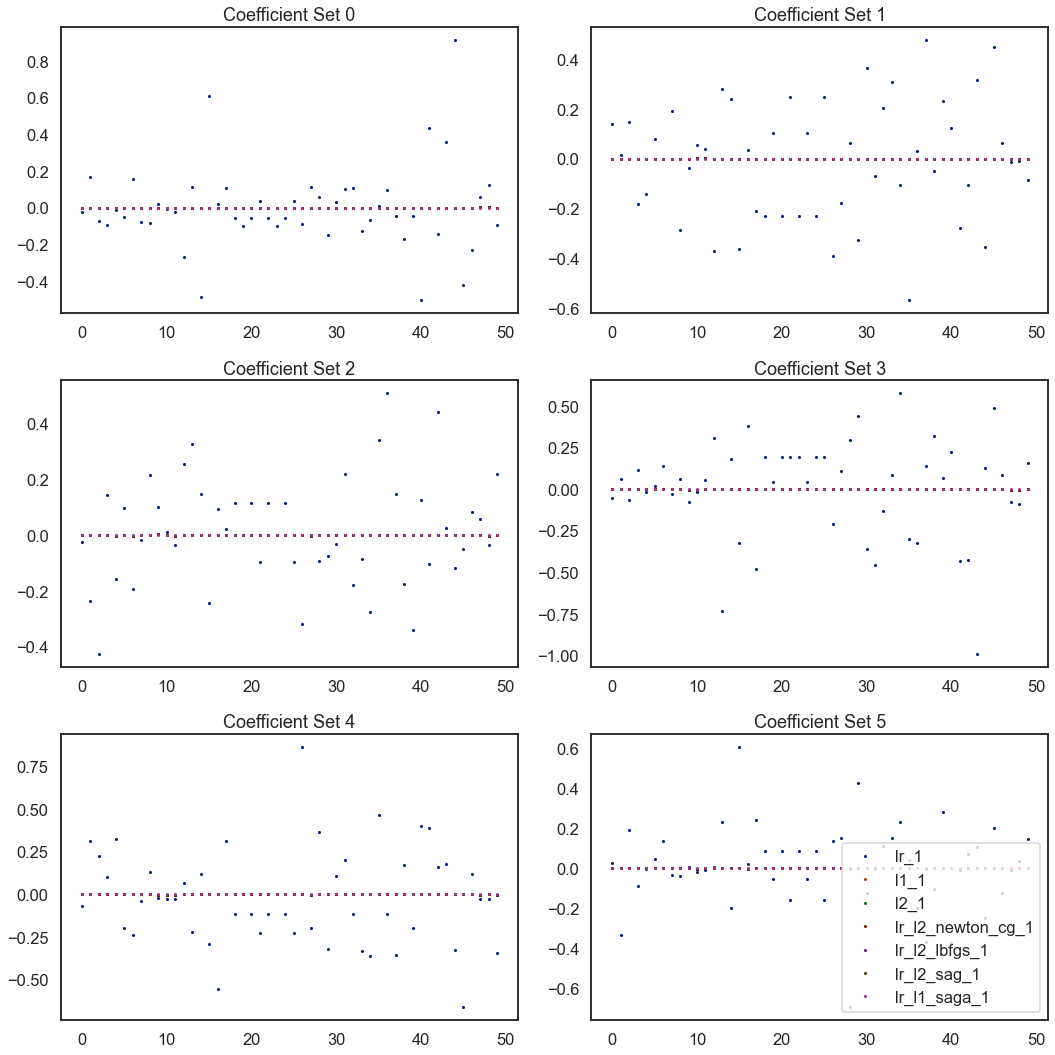

In [82]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15,15)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients1.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[5]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [83]:
# Predict the class and the probability for each



y_pred_new = list()
y_prob_new = list()

coeff_labels_1 = ['lr_1', 'l1_1', 'l2_1','lr_l2_newton_cg_1','lr_l2_lbfgs_1','lr_l2_sag_1','lr_l1_saga_1']
coeff_models_1 = [lr_1, lr_l1_1, lr_l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1]

for lab,mod in zip(coeff_labels_1, coeff_models_1):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0
4,0,2,2,2,2,2,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [84]:
# Calculate the error metrics as listed above

In [85]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics_new = list()
cm_new = dict()

for lab in coeff_labels_1:

    # Çok sınıflı destek fonksiyonunda Precision, recall, f-score 
    precision, recall, fscore, _ = score(Y_test_new, y_pred_new[lab], average='weighted')
    
    # accuracy'yi hesaplamanın olağan yolu
    accuracy = accuracy_score(Y_test_new, y_pred_new[lab])
    
    # ROC-AUC skorları verilerin ikilileştirilmesi(binarizing) ile hesaplanabilir
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Son olarak, confusion matrix
    cm_new[lab] = confusion_matrix(Y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)


C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aabdu\anaconda3\lib\site-packages\sklearn\metr

In [86]:
#Run the metrics
metrics_new

,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
precision,0.162955,0.070514,0.070514,0.070514,0.070514,0.070514,0.035038
recall,0.180194,0.192621,0.192621,0.192621,0.192621,0.192621,0.187184
fscore,0.149893,0.100397,0.100397,0.100397,0.100397,0.100397,0.059027
accuracy,0.180194,0.192621,0.192621,0.192621,0.192621,0.192621,0.187184
auc,0.500959,0.504664,0.504664,0.504664,0.504664,0.504664,0.500000


In [87]:
type(metrics_new)

pandas.core.frame.DataFrame

## Question 13

Display or plot the confusion matrix for each model.

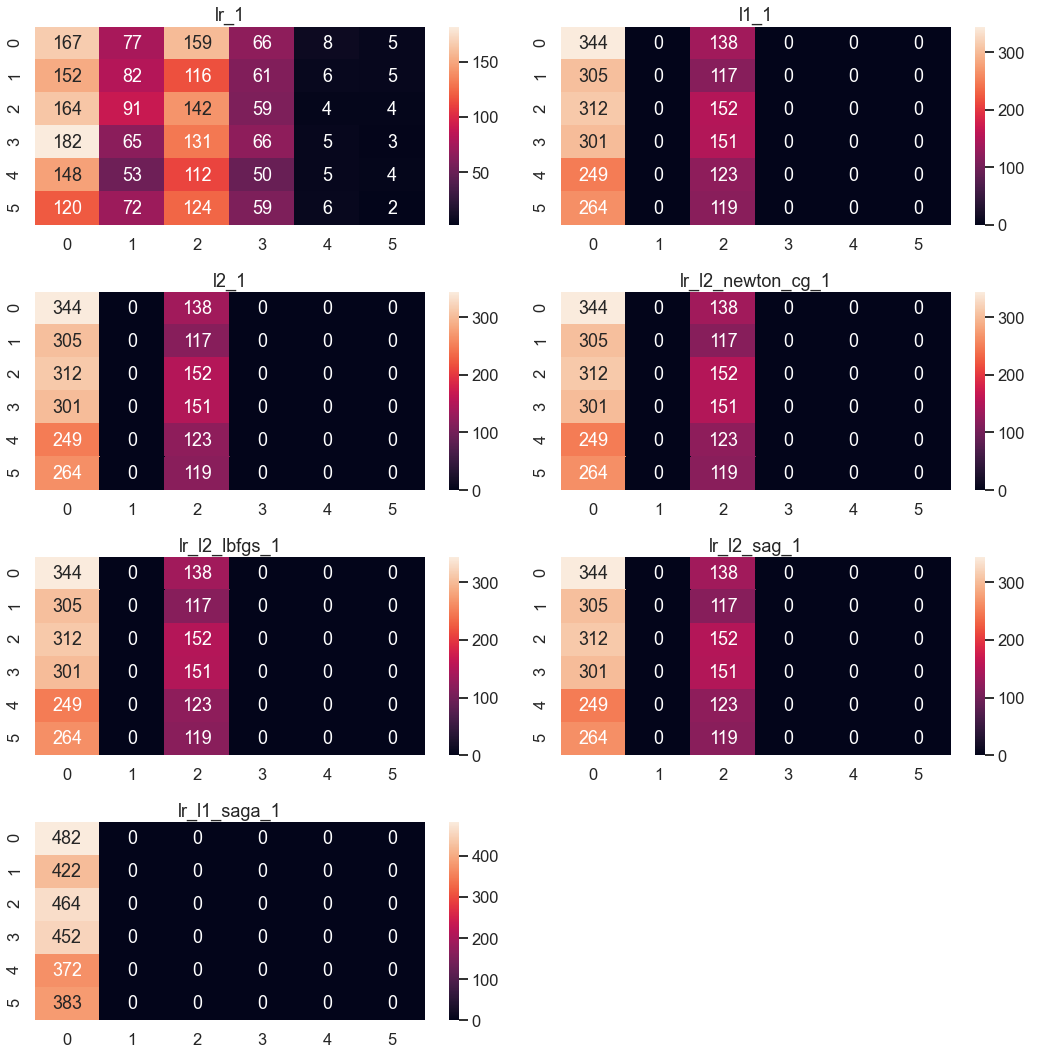

In [88]:
#plot the confusion matrix


fig, axList = plt.subplots(nrows=4, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15, 15)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels_1):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [89]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
#qes 7-----> metrics
#qes 12-----> metrics_new

frames = [metrics.T,metrics_new.T]
result = pd.concat(frames)
result=result.T
result


,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
precision,0.980246,0.984153,0.983811,0.983485,0.983811,0.984456,0.983810,0.162955,0.070514,0.070514,0.070514,0.070514,0.070514,0.035038
recall,0.980259,0.984142,0.983819,0.983495,0.983819,0.984466,0.983819,0.180194,0.192621,0.192621,0.192621,0.192621,0.192621,0.187184
fscore,0.980248,0.984140,0.983811,0.983488,0.983811,0.984459,0.983812,0.149893,0.100397,0.100397,0.100397,0.100397,0.100397,0.059027
accuracy,0.980259,0.984142,0.983819,0.983495,0.983819,0.984466,0.983819,0.180194,0.192621,0.192621,0.192621,0.192621,0.192621,0.187184
auc,0.988042,0.990342,0.990167,0.989983,0.990167,0.990564,0.990162,0.500959,0.504664,0.504664,0.504664,0.504664,0.504664,0.500000


In [90]:

for lab1,lab2 in zip(coeff_labels,coeff_labels_1):
  print('[' + lab1 +" & "+lab2+']'+"======================================================================================================")
  print('')
  f = [result[lab1],result[lab2]]
  result1 = pd.concat(f,axis=1)
  print(result1)


[lr & lr_1]======================================================================================================

                 lr      lr_1
precision  0.980246  0.162955
recall     0.980259  0.180194
fscore     0.980248  0.149893
accuracy   0.980259  0.180194
auc        0.988042  0.500959
[l1 & l1_1]======================================================================================================

                 l1      l1_1
precision  0.984153  0.070514
recall     0.984142  0.192621
fscore     0.984140  0.100397
accuracy   0.984142  0.192621
auc        0.990342  0.504664
[l2 & l2_1]======================================================================================================

                 l2      l2_1
precision  0.983811  0.070514
recall     0.983819  0.192621
fscore     0.983811  0.100397
accuracy   0.983819  0.192621
auc        0.990167  0.504664
[lr_l2_newton_cg & lr_l2_newton_cg_1]==============================================================================

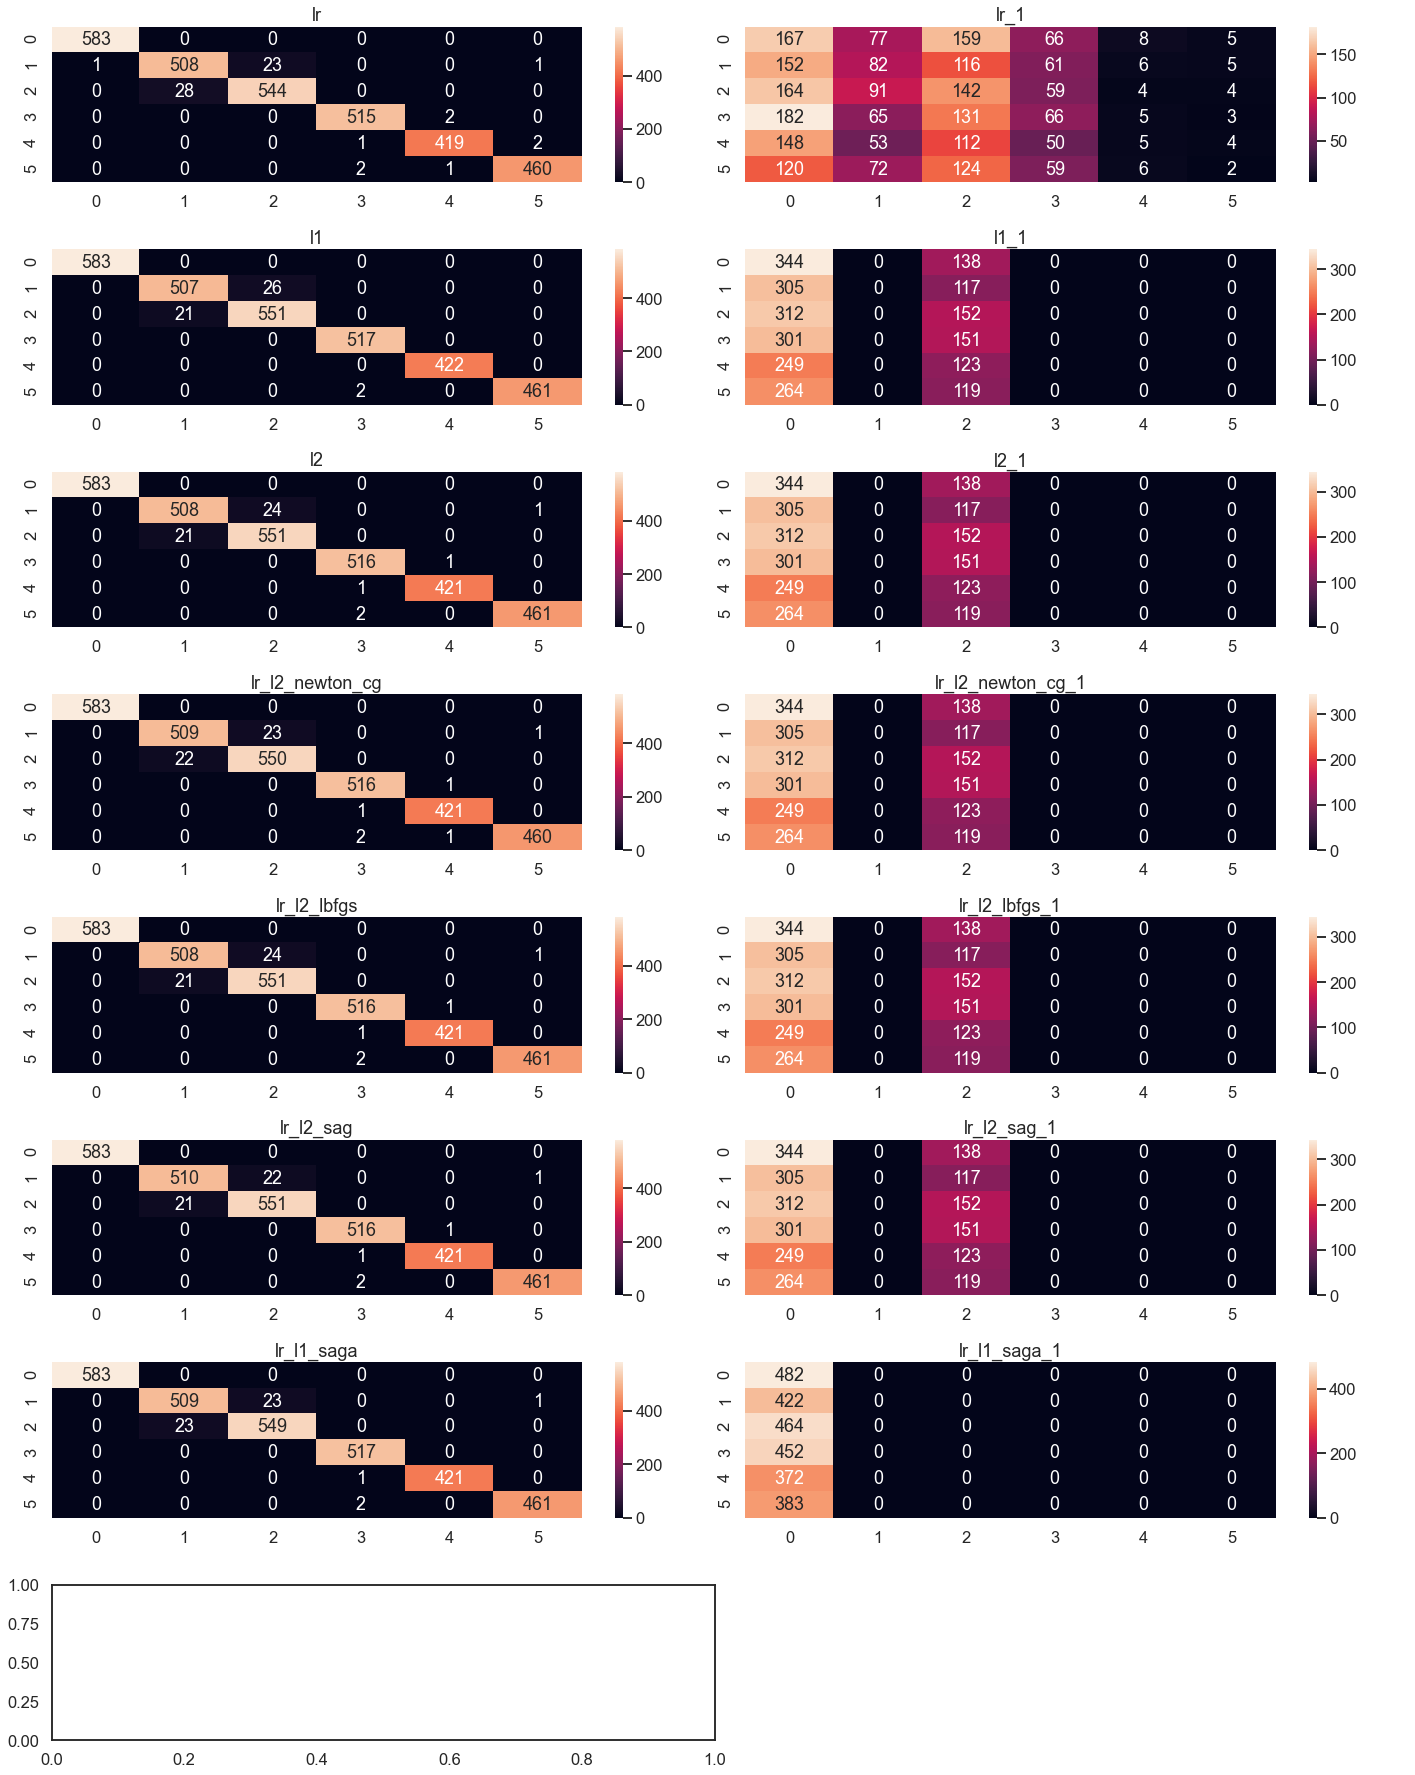

In [91]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation
CM = dict(list(cm.items()) + list(cm_new.items()))

#lb=coeff_labels+coeff_labels_1
lb = ['lr','lr_1', 'l1','l1_1', 'l2'  , 'l2_1'  , 'lr_l2_newton_cg', 'lr_l2_newton_cg_1' , 'lr_l2_lbfgs', 'lr_l2_lbfgs_1' , 'lr_l2_sag' , 'lr_l2_sag_1', 'lr_l1_saga', 'lr_l1_saga_1']
fig, axList = plt.subplots(nrows=8, ncols=2)
axList = axList.flatten()
fig.set_size_inches(20, 25)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], lb):
    sns.heatmap(CM[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

